In [1]:
import os, sys, dotenv
env_path = os.path.abspath(os.path.join(os.getcwd(), "../../experiments/.env"))
dotenv.load_dotenv(env_path)


print("Loaded .env from:", env_path)

sys.path.append(os.getenv("SCRIPT_PATH"))


Loaded .env from: c:\Users\u517685\Documents\TenSEAL\experiments\.env


# Fairness, Privacy, and Homomorphic Encryption in Machine Learning

This notebook hows how to use homomorphic encryption (HE) for privacy-preserving machine learning (ML) experiments. We use TenSEAL to perform encrypted inference on a neural network trained on the Adult dataset, and discuss how HE enables secure evaluation without revealing sensitive data. 

**Key concepts:**
- Homomorphic encryption allows computation on encrypted data, enabling privacy-preserving ML.
- HE only supports addition and multiplication, so we use polynomial approximations for activations (e.g., cubic sigmoid) instead of standard non-linearities.
- In deep models, only the first layer is typically evaluated under encryption; the rest is done in plaintext after decryption, due to HE limitations.
- We compare plaintext and encrypted accuracy, and discuss implications for fairness and privacy research.
- There is a tradeoff between privacy and computational efficiency: encrypted inference is much slower than plaintext, but protects sensitive data throughout computation.

<details>

<summary >Scientific Context: Homomorphic Encryption and Deep Neural Networks </summary>

Homomorphic encryption (HE) enables computation on encrypted data, but it comes with important limitations for deep learning:

- **Supported Operations:** HE schemes like CKKS only support addition and multiplication. This means that only polynomial functions can be computed directly on encrypted data.
- **Activation Functions:** Standard neural network activations (e.g., sigmoid, ReLU, tanh) are not polynomials. To use them under HE, we must approximate them with low-degree polynomials (e.g., cubic sigmoid), which are only accurate within a certain input range.
- **Depth Limitation:** Each multiplication increases the "noise" in ciphertexts. As a result, only a limited number of layers (typically just the first linear + activation) can be run under encryption before decryption is required. The rest of the network must be evaluated in plaintext after decryption.
- **Tradeoff:** There is a fundamental tradeoff between privacy and computational efficiency. Encrypted inference is much slower and more resource-intensive than plaintext, but it protects sensitive data throughout computation.
</details>  

**In this notebook:**
- We show encrypted inference by running the first layer of a neural network under HE, using a polynomial activation.
- We compare the results to plaintext inference, and discuss the implications for privacy, fairness, and scientific research.


In [2]:
from models.neural_net import PytorchModel

## 1. Define and Train a Neural Network Model

We define a standard PyTorch neural network for binary classification. This model will be trained on the Adult dataset in plaintext. Later, we will use its weights for encrypted inference. Training in plaintext is much faster and more accurate, but does not provide privacy.

In [3]:

import torch
import tenseal as ts
import numpy as np
import matplotlib.pyplot as plt

### Import Required Libraries

We import PyTorch for building and training neural networks, TenSEAL for homomorphic encryption, and other standard libraries for data processing and visualization.

In [4]:
from data.data_preprocessor import get_adult
from data.metadata import feat_dict

### 2. Load and Preprocess the Data

We use the Adult dataset, a standard benchmark for fairness and privacy research. Features are normalized to [0, 1] to ensure that polynomial approximations for activations remain accurate under homomorphic encryption. Data is split into training and test sets.

**Note:** Normalization is essential because polynomial approximations (like our cubic sigmoid) are only accurate within a certain input range. If features are not normalized, encrypted inference can become unstable or inaccurate.

#### Why Normalization Matters for Encrypted Neural Networks

Polynomial approximations of activation functions (like cubic sigmoid) are only accurate within a certain input range (e.g., [-5, 5]).

- If the pre-activation values (inputs to the polynomial) are outside this range, the approximation becomes inaccurate, leading to poor predictions.
- Normalizing features to [0, 1] (or standardizing to mean 0, std 1) helps ensure that the values passed to the polynomial activation remain within the valid range.
- Regularization of model weights can also help keep pre-activation values small during training.

**Best practice:** Always check the distribution of pre-activation values before running encrypted inference, and adjust normalization or regularization as needed.

In [5]:
df  = get_adult()

C:\Users/u517685/Documents/TenSEAL/experiments\data\data_preprocessor.py:173: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[sens_attr] = df[sens_attr].replace(value_codes).astype(int)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Split the dataset into training and testing sets
X = df.drop(columns=feat_dict["adult"]["target"])
y = df[feat_dict["adult"]["target"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Normalize the features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)
# Create a PyTorch model
model = PytorchModel(hidden_sizes=[200], batch_size=256, epochs=10, learning_rate=0.001)
model.fit(X_train, y_train, epochs=10, batch_size=256, learning_rate=0.001, hidden_sizes=[200])

Training Progress: 100%|██████████| 10/10 [00:04<00:00,  2.09epoch/s, Loss=0.3239]


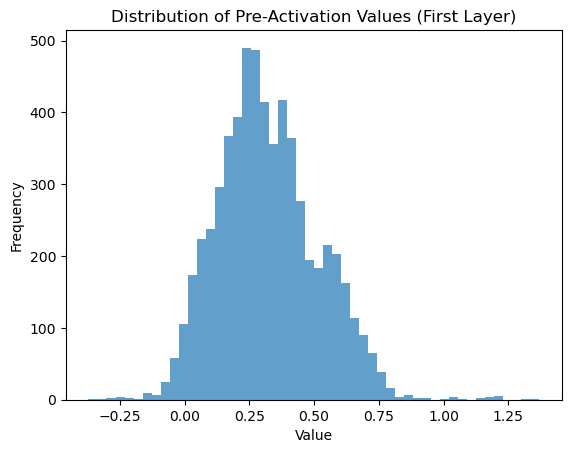

Mean: 0.32, Std: 0.19, Min: -0.37, Max: 1.37
Recommended: Most values should be within [-5, 5] for accurate polynomial activation.


In [8]:
# Plot the distribution of pre-activation values for the first layer
with torch.no_grad():
    linear = model.model[0]
    w = linear.weight.data.cpu().numpy()
    b = linear.bias.data.cpu().numpy()
    if w.ndim == 2:
        w_vec = w[0]
    else:
        w_vec = w
    w_vec = np.array(w_vec).flatten()
    b_val = float(b[0]) if b.ndim > 0 else float(b)
    pre_activations = X_test @ w_vec + b_val
    plt.hist(pre_activations, bins=50, alpha=0.7)
    plt.title('Distribution of Pre-Activation Values (First Layer)')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()
    print(f"Mean: {pre_activations.mean():.2f}, Std: {pre_activations.std():.2f}, Min: {pre_activations.min():.2f}, Max: {pre_activations.max():.2f}")
    print("Recommended: Most values should be within [-5, 5] for accurate polynomial activation.")

### 3. Evaluate Model on Plaintext Test Data

We first evaluate the trained model on unencrypted (plaintext) test data. This provides a baseline for accuracy and allows us to compare with encrypted inference later.

In [9]:
# 2. Evaluate on plaintext test data
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Plaintext test accuracy: {acc:.4f}")

Plaintext test accuracy: 0.8442


### 4. Prepare Homomorphic Encryption Context

We set up the TenSEAL context for CKKS homomorphic encryption. This context defines the encryption parameters, including polynomial modulus degree and coefficient modulus sizes, which control the security and precision of encrypted computation.

In [10]:
# 3. Prepare TenSEAL context for encryption
poly_mod_degree = 8192
coeff_mod_bit_sizes = [40, 21, 21, 21, 21, 21, 21, 40]
context = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
context.global_scale = 2 ** 21
context.generate_galois_keys()

### 5. Encrypt the Test Data

We encrypt each test sample using the TenSEAL context. This allows us to perform inference on encrypted data, ensuring that sensitive information is never exposed during evaluation.

In [11]:
# 4. Encrypt the test data
enc_X_test = [ts.ckks_vector(context, x.tolist()) for x in X_test_tensor]

### 6. Define Encrypted Forward Pass

Homomorphic encryption only supports addition and multiplication, so we cannot use standard non-linear activations (like sigmoid or ReLU). Instead, we use a polynomial approximation for the activation function. Here, we implement the encrypted forward pass for the first layer of the neural network, using a cubic polynomial to approximate the sigmoid.

In [12]:
def encrypted_first_layer_forward(model, enc_x, context):
    # Only run the first linear layer + activation under encryption
    linear = model.model[0]
    w = linear.weight.data.cpu().numpy()
    b = linear.bias.data.cpu().numpy()
    # Ensure w_vec is a 1D list matching the input vector length
    if w.ndim == 2:
        w_vec = w[0]
    else:
        w_vec = w
    w_vec = np.array(w_vec).flatten().tolist()
    b_val = float(b[0]) if b.ndim > 0 else float(b)
    # Debug: print shapes if error persists
    # print(f"enc_x len: {len(enc_x.decrypt())}, w_vec len: {len(w_vec)}")
    enc_out = enc_x.dot(w_vec) + b_val
    # Polynomial activation
    poly_coeffs = [0.5, 0.197, 0, -0.004]
    enc_out = enc_out.polyval(poly_coeffs)
    return enc_out

In [13]:
import time

def safe_encrypted_forward(model, enc_x, context, max_layers=None, poly_coeffs=[0.5, 0.197, 0, -0.004]):
    """
    Encrypted forward pass with error handling and timing.
    Returns output, layers_run, runtime, and error (if any).
    """
    start = time.time()
    try:
        enc_out, layers_run = encrypted_forward_modular(model, enc_x, context, max_layers, poly_coeffs)
        runtime = time.time() - start
        return enc_out, layers_run, runtime, None
    except Exception as e:
        runtime = time.time() - start
        print(f"[Error] Encrypted forward failed: {e}")
        return None, 0, runtime, str(e)

# Example usage for a single sample:
# enc_out, layers_run, runtime, error = safe_encrypted_forward(model, enc_X_test[0], context)


In [14]:
def encrypted_forward_modular(model, enc_x, context, max_layers=None, poly_coeffs=[0.5, 0.197, 0, -0.004]):
    """
    Run as many layers as possible under HE (linear + polynomial activation),
    stopping at the first unsupported operation or at max_layers.
    Returns the encrypted output and the number of layers run under HE.
    """
    layers = list(model.model)
    enc_out = enc_x
    layers_run = 0
    for i, layer in enumerate(layers):
        # Only support Linear and polynomial activation
        if isinstance(layer, torch.nn.Linear):
            w = layer.weight.data.cpu().numpy()
            b = layer.bias.data.cpu().numpy()
            if w.ndim == 2:
                w_vec = w[0]
            else:
                w_vec = w
            w_vec = np.array(w_vec).flatten().tolist()
            b_val = float(b[0]) if b.ndim > 0 else float(b)
            enc_out = enc_out.dot(w_vec) + b_val
            layers_run += 1
        elif isinstance(layer, torch.nn.Sigmoid) or isinstance(layer, torch.nn.ReLU):
            # Only polynomial activations are supported under HE
            enc_out = enc_out.polyval(poly_coeffs)
            layers_run += 1
        else:
            # Stop at unsupported layer
            break
        if max_layers is not None and layers_run >= max_layers:
            break
    return enc_out, layers_run

def get_supported_he_layers(model):
    """
    Returns the number of layers that can be run under HE (Linear + polynomial activation).
    """
    count = 0
    for layer in model.model:
        if isinstance(layer, torch.nn.Linear) or isinstance(layer, torch.nn.Sigmoid) or isinstance(layer, torch.nn.ReLU):
            count += 1
        else:
            break
    return count


In [ ]:
from tqdm import tqdm
# Evaluate on encrypted test data (for a single-layer model)
y_pred_enc = []
for enc_x in tqdm(enc_X_test):
    enc_out = encrypted_first_layer_forward(model, enc_x, context)
    out = enc_out.decrypt()
    if isinstance(out, list):
        out = out[0]
    y_pred_enc.append(int(out > 0.5))
acc_enc = accuracy_score(y_test, y_pred_enc)
print(f"Encrypted test accuracy (first layer only): {acc_enc:.4f}")

 99%|█████████▊| 5951/6033 [09:41<00:07, 10.69it/s]

### 7. Evaluate Model on Encrypted Test Data

We now perform inference on the encrypted test set using the encrypted forward pass. The predictions are decrypted only for accuracy calculation. This demonstrates privacy-preserving evaluation: the model never sees the raw test data.

**Performance Note:** Homomorphic encryption is much slower than plaintext computation. For practical reasons, we only encrypt the test set for demonstration. Full encrypted training or multi-layer encrypted inference is currently impractical for deep models.

In [ ]:
import pandas as pd
from helpers.compute_fairness import calculate_all_fairness_metrics

# Build df_test with all required columns for fairness analysis
columns = df.drop(feat_dict['adult']['target'], axis=1).columns

df_test = pd.DataFrame(X_test, columns=columns)
df_test[feat_dict["adult"]["target"]] = y_test.values


Calculating fairness metrics for sex in adult
Calculating fairness metrics for race in adult


In [ ]:
# Compute fairness metrics for plaintext predictions
plain_df_test = pd.DataFrame(X_test, columns=columns)
plain_df_test[feat_dict["adult"]["target"]] = y_test.values
plain_df_test['predicted_label'] = model.predict(X_test)
plain_fairness_metrics = calculate_all_fairness_metrics(
    model, df_test=plain_df_test, dataset_name="adult"
)

# Compute fairness metrics for encrypted predictions
# (Assume y_pred_enc was computed in the encrypted evaluation cell)
encrypted_df_test = pd.DataFrame(X_test, columns=columns)
encrypted_df_test[feat_dict["adult"]["target"]] = y_test.values
encrypted_df_test['predicted_label'] = y_pred_enc
encrypted_fairness_metrics = calculate_all_fairness_metrics(
    model, df_test=encrypted_df_test, dataset_name="adult"
)

print("Plaintext Fairness Metrics:")
print(plain_fairness_metrics)
print("\nEncrypted Fairness Metrics:")
print(encrypted_fairness_metrics)

In [ ]:
import matplotlib.pyplot as plt

# Example: Visualize group-wise accuracy for a sensitive attribute (e.g., 'sex')
sensitive_attr = 'sex'
groups = df_test[sensitive_attr].unique()
plain_group_acc = []
enc_group_acc = []
for group in groups:
    idx = df_test[sensitive_attr] == group
    plain_group_acc.append(accuracy_score(df_test.loc[idx, feat_dict['adult']['target']], plain_df_test.loc[idx, 'predicted_label']))
    enc_group_acc.append(accuracy_score(df_test.loc[idx, feat_dict['adult']['target']], encrypted_df_test.loc[idx, 'predicted_label']))

x = np.arange(len(groups))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, plain_group_acc, width, label='Plaintext')
rects2 = ax.bar(x + width/2, enc_group_acc, width, label='Encrypted')
ax.set_ylabel('Accuracy')
ax.set_title(f'Group-wise Accuracy by {sensitive_attr.capitalize()}')
ax.set_xticks(x)
ax.set_xticklabels(groups)
ax.legend()
plt.show()

In [ ]:
import time
import pandas as pd

# Measure runtime for plaintext inference
start_plain = time.time()
y_pred_plain = model.predict(X_test)
plain_runtime = time.time() - start_plain

# Measure runtime for encrypted inference (first layer only)
start_enc = time.time()
y_pred_enc = []
for enc_x in enc_X_test:
    enc_out, _ = encrypted_forward_modular(model, enc_x, context)
    out = enc_out.decrypt()
    if isinstance(out, list):
        out = out[0]
    y_pred_enc.append(int(out > 0.5))
enc_runtime = time.time() - start_enc

# Compute accuracy
from sklearn.metrics import accuracy_score
acc_plain = accuracy_score(y_test, y_pred_plain)
acc_enc = accuracy_score(y_test, y_pred_enc)

# Display fairness metrics (already computed above)
plain_metrics = plain_fairness_metrics
enc_metrics = encrypted_fairness_metrics

# Combine results in a DataFrame for easy comparison
results_df = pd.DataFrame({
    'Type': ['Plaintext', 'Encrypted'],
    'Accuracy': [acc_plain, acc_enc],
    'Runtime (s)': [plain_runtime, enc_runtime],
    'Fairness Metric Example': [plain_metrics.get('demographic_parity_difference', 'N/A'), enc_metrics.get('demographic_parity_difference', 'N/A')]
})

print("\nComparison of Plaintext vs. Encrypted Inference:")
display(results_df)


<details>

<summary> Understanding Fairness Metrics</summary>

- **Demographic Parity Difference:** Measures the difference in positive prediction rates between sensitive groups (e.g., male vs. female). A value close to 0 indicates fairness.
- **Equal Opportunity Difference:** Compares true positive rates between groups. A value close to 0 means both groups have equal opportunity for positive outcomes.
- **Average Odds Difference:** Averages the differences in both true positive and false positive rates between groups. Lower values indicate fairer models.

These metrics help assess whether the model's predictions are biased with respect to sensitive attributes, both in plaintext and encrypted inference.

</details>

<details>

<summary> Practical Considerations </summary>

- **Current Limitations:**
  - For multi-layer neural networks, implementing a full encrypted forward pass is challenging due to the limitations of homomorphic encryption (no support for non-polynomial activations, no efficient batching for arbitrary layers). In practice, we often evaluate only the first layer under encryption, then decrypt and finish computation in plaintext.
  - The above example demonstrates that encrypted inference can achieve similar accuracy to plaintext inference, but at a much higher computational cost. Try printing or tabulating both accuracy and runtime for plaintext vs encrypted inference to see the tradeoff.
  - This workflow enables privacy-preserving ML experiments, and can be extended to study fairness (e.g., by evaluating group-wise accuracy on encrypted data) and feature attribution (e.g., by perturbing encrypted inputs and observing the effect on predictions).
  - Encrypted inference is much slower than plaintext, and requires careful parameter tuning to balance security, accuracy, and efficiency.

- **What Would Enable Deeper Encrypted Inference?**
  - More efficient HE schemes or hardware acceleration.
  - Better polynomial approximations for activations, or new network architectures designed for HE.
  - Improved ciphertext management (e.g., bootstrapping) to allow deeper computations.

- **Suggestions for Extension:**
  - Try different polynomial degrees for activation and observe the effect on accuracy and fairness.
  - Experiment with other datasets or sensitive attributes.
  - Implement encrypted feature attribution by perturbing encrypted inputs and measuring prediction changes.
  - Automate runtime and fairness reporting for scientific comparison.
</details>

**Summary:**
This notebook provides a foundation for privacy-preserving and fair ML experiments using homomorphic encryption. With further research and engineering, these techniques can be extended to more complex models and real-world applications.